## 1. Data

In [1]:
# Import the libraries
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [174]:
# Read the hero-network.csv data
heroNetwork = pd.read_csv(os.getcwd()+"/Data/hero-network.csv")

In [151]:
# lenght of the data
len(heroNetwork)

574467

As we can see, the lenght of the heroNetwork data is 574467. This data shows the edges between heroes that appear in the same comic. 

In [152]:
heroNetwork.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574467 entries, 0 to 574466
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   hero1   574467 non-null  object
 1   hero2   574467 non-null  object
dtypes: object(2)
memory usage: 8.8+ MB


In [175]:
# Convert our heroNetwork to a dataframe
heroNetworkDf = pd.DataFrame(heroNetwork)

In [154]:
heroNetworkDf

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
...,...,...
574462,COLOSSUS II/PETER RA,CALLISTO
574463,CALLISTO,ROGUE /
574464,CALLISTO,CALIBAN/
574465,CALIBAN/,ROGUE /


In [179]:
# Read the edges.csv data
edges = pd.read_csv(os.getcwd()+"/Data/edges.csv")

In [180]:
# Convert the edges data to dataframe
edgesDf = pd.DataFrame(edges)

In [157]:
edgesDf

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


### Data Preprocessing

#### 1. Some of the heroes' names in 'hero-network.csv' are not found in 'edges.csv'. This inconsistency will be solved in the bellow codes:

In [176]:
# Write a function to return the differences between two files
def compare(string1, string2):
    temp= []
    for i in string1:
        if i not in string2:
            temp.append(i)
    return temp

In [181]:
# Find the differnces between to files that have to modify
merge = heroNetworkDf.hero1.tolist() + heroNetworkDf.hero2.tolist()
unique = list(set(merge))
differ = compare(unique, list(edgesDf.hero))
differ

['LEVIATHAN II/EDWARD ',
 'MORNING STAR/ZVEZDA ',
 'PAINTER/WILHELM VON ',
 'LIVING LASER/ARTHUR ',
 'SNOWBIRD/NARYA/ANNE ',
 'BEETLE/ABNER RONALD ',
 'VISION ',
 'WOLVERINE/LOGAN ',
 'BRADDOCK, JAMES JR. ',
 'HOBGOBLIN III/LEFTY ',
 'GREEN GOBLIN/NORMAN ',
 'QUASAR DOPPELGANGER ',
 'MISSING LINK II/RAY ',
 'WATSON-PARKER, MARY ',
 'DR. SPECTRUM/JOSEPH ',
 'MANN, DR. J. VERNON ',
 'PESTILENCE | MUTANT ',
 'WASP/JANET VAN DYNE ',
 'SPAR, DR. KATHERINE ',
 'DEATH STING/MIRANDA ',
 'HAVOK/ALEX SUMMERS ',
 'POWERSURGE/ILLARION ',
 'MODULAR MAN/STEPHEN ',
 'ERISHKIGEL II/HOLLY ',
 'NORTHSTAR/JEAN-PAUL ',
 'GRIZZLY II/THEODORE ',
 'GAMBIT DOPPELGANGER ',
 'FOOLKILLER III/KURT ',
 'COPPERHEAD/LAWRENCE ',
 'WILD CHILD | MUTANT ',
 'ROSS, GEN. THADDEUS ',
 'AUGUST PERSONAGE IN ',
 'SHOCKWAVE/LANCASTER ',
 'BLACK BOLT | MUTANT ',
 'FURY, NICK | MUTANT ',
 'WORTHINGTON, WARREN ',
 'MORBIUS/DR. MICHAEL ',
 'MADDICKS, PROFESSOR ',
 'RIGHT-WINGER/JEROME ',
 'BLACK AVENGER/JERRY ',
 'TRITON DOPPELGAN

In [182]:
# Delete the words that don't have extra space from the differ list
differInEdge2 = ['BLADE' , 'SABRE' , 'SPIDER-MAN/PETER PAR']
for elem in differInEdge2:
    differ.remove(elem)
differ

['LEVIATHAN II/EDWARD ',
 'MORNING STAR/ZVEZDA ',
 'PAINTER/WILHELM VON ',
 'LIVING LASER/ARTHUR ',
 'SNOWBIRD/NARYA/ANNE ',
 'BEETLE/ABNER RONALD ',
 'VISION ',
 'WOLVERINE/LOGAN ',
 'BRADDOCK, JAMES JR. ',
 'HOBGOBLIN III/LEFTY ',
 'GREEN GOBLIN/NORMAN ',
 'QUASAR DOPPELGANGER ',
 'MISSING LINK II/RAY ',
 'WATSON-PARKER, MARY ',
 'DR. SPECTRUM/JOSEPH ',
 'MANN, DR. J. VERNON ',
 'PESTILENCE | MUTANT ',
 'WASP/JANET VAN DYNE ',
 'SPAR, DR. KATHERINE ',
 'DEATH STING/MIRANDA ',
 'HAVOK/ALEX SUMMERS ',
 'POWERSURGE/ILLARION ',
 'MODULAR MAN/STEPHEN ',
 'ERISHKIGEL II/HOLLY ',
 'NORTHSTAR/JEAN-PAUL ',
 'GRIZZLY II/THEODORE ',
 'GAMBIT DOPPELGANGER ',
 'FOOLKILLER III/KURT ',
 'COPPERHEAD/LAWRENCE ',
 'WILD CHILD | MUTANT ',
 'ROSS, GEN. THADDEUS ',
 'AUGUST PERSONAGE IN ',
 'SHOCKWAVE/LANCASTER ',
 'BLACK BOLT | MUTANT ',
 'FURY, NICK | MUTANT ',
 'WORTHINGTON, WARREN ',
 'MORBIUS/DR. MICHAEL ',
 'MADDICKS, PROFESSOR ',
 'RIGHT-WINGER/JEROME ',
 'BLACK AVENGER/JERRY ',
 'TRITON DOPPELGAN

In [183]:
# Deleting the extra space from the end of the some words in heroNetworkDf
for col in heroNetworkDf.columns:
    heroNetworkDf[col] = heroNetworkDf[col].apply(lambda x: x[0:-1] if x in differ else x)

In [40]:
heroNetworkDf.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [184]:
# Cleaning edgesDf from the extra '/'
edgesDf.hero = edgesDf.hero.apply(lambda x: x[0:-1] if x in ["BLADE/", "SABRE/"] else x)

In [185]:
edgesDf[edgesDf.hero=="BLADE"]

,hero,comic
8001,BLADE,AIF 24
8002,BLADE,BLADE
8003,BLADE,DRSTR2 61
8004,BLADE,DRSTR2 62
8005,BLADE,DRSTR2 67
8006,BLADE,GR3 31
8007,BLADE,M/CP 64/4
8008,BLADE,M/PRV 3
8009,BLADE,M/PRV 8/2
8010,BLADE,M/TU2 7


In [186]:
# Fix the name 'SPIDER-MAN/PETER PAR' in 'hero-network.csv'
for col in heroNetworkDf.columns:
        heroNetworkDf[col] = heroNetworkDf[col].apply(lambda x: 'SPIDER-MAN/PETER PARKER' if x=='SPIDER-MAN/PETER PAR' else x)

In [187]:
# Check if there is any differences between the hero's names in 2 files
merge = heroNetworkDf.hero1.tolist() + heroNetworkDf.hero2.tolist()
unique2 = list(set(merge))
differ2 = compare(unique2, list(edgesDf.hero))
differ2

[]

In [111]:
# Save the modified version of edges file as csv
edgesDf.to_csv(os.getcwd()+"/Data/edgesModified.csv", index=False , header = True)

In [13]:
edgesDf = pd.read_csv(os.getcwd()+"/Data/edgesModified.csv")

As we can see, we got the blank list from the compare function. It means all tree reasons that caused inconsistency were fixed.

#### 2. Some entries in the 'hero-network.csv' have the same hero in both columns. We will handle it in the following codes:

In [188]:
# Delete the rows that have the same hero in both columns
heroNetworkDf = heroNetworkDf[heroNetworkDf.hero1!=heroNetworkDf.hero2] 

In [189]:
# Save the modified heroNetworkDF as csv files
heroNetworkDf.to_csv(os.getcwd()+"/Data/heroNetworkModified.csv", index=False , header = True)

In [ ]:
# Save the modified heroNetworkDF as csv file
heroNetworkDf.to_csv(os.getcwd()+"/Data/heroNetworkModified.csv", index=False , header = True)

In [2]:
# Read the modified file
heroNetworkModified = pd.read_csv(os.getcwd()+"/Data/heroNetworkModified.csv")

In [3]:
# Convert the modified file to the csv
heroNetworkDfModified = pd.DataFrame(heroNetworkModified)

### Making Graphs

#### 1.First Graph

For each pair of nodes (ie for each edge), we have two attributes :
1. capicity : number of links between the two nodes (necessary for functionality 4)
2. weight : 1/capicity 

In [4]:
full_df_size = heroNetworkDfModified.groupby(['hero1', 'hero2'], as_index=False).size()

full_df_size = full_df_size.rename(columns={'size':'capacity'})

full_df_size['weight'] = 1/full_df_size['capacity']

full_df_size

,hero1,hero2,capacity,weight
0,24-HOUR MAN/EMMANUEL,"FROST, CARMILLA",1,1.0
1,24-HOUR MAN/EMMANUEL,KILLRAVEN/JONATHAN R,1,1.0
2,24-HOUR MAN/EMMANUEL,M'SHULLA,1,1.0
3,3-D MAN/CHARLES CHAN,ANGEL/WARREN KENNETH,1,1.0
4,3-D MAN/CHARLES CHAN,ANT-MAN II/SCOTT HAR,1,1.0
...,...,...,...,...
224094,ZZZAX,"RODRIGUEZ, DEBRA",1,1.0
224095,ZZZAX,"ROSS, GEN. THADDEUS",2,0.5
224096,ZZZAX,"SUMMERS, NATHAN CHRI",1,1.0
224097,ZZZAX,TIGRA/GREER NELSON,1,1.0


In [5]:
# Making the first weighted and undirected graph from the heroNetworkDfModified data
GHeroNet = nx.from_pandas_edgelist(full_df_size, source='hero1', target='hero2', edge_attr=['weight', 'capacity'], 
                                   create_using=nx.MultiGraph(), edge_key=None)
                                

We can notice that for each pair of nodes, we can have two different lists of attributes on some edges :

In [244]:
GHeroNet.get_edge_data('ABRAXAS','FROST, CARMILLA')

{0: {'weight': 1.0, 'capacity': 1}, 1: {'weight': 0.5, 'capacity': 2}}

In [27]:
GHeroNet.get_edge_data('FROST, CARMILLA','ABRAXAS')

{0: {'weight': 1.0, 'capacity': 1}, 1: {'weight': 0.5, 'capacity': 2}}

This is because each pair of nodes was not necessarily added in the dataset each time in the same order.
For example, if in a comic A, we have SpiderMan and CaptainAmerica and this pair is added with SpiderMan as hero1 and CaptainAmerica as hero2. Then, we can have a comic B where they reappear together and this time the pair will be added with CaptainAmerica in hero1 and SpiderMan in hero2.

Let's recreate this undirected graph in order to have only one edge between each pair of nodes. Also, we want to recalculate capacities and weights for each edge to have only one correct value.

In [33]:
G_heroes = nx.Graph()

for edge in tqdm(GHeroNet.edges) :
    if edge[2] == 0 :
        links_dico_values = GHeroNet.get_edge_data(edge[0], edge[1]).values()
        total_capacity = 0
        for values in links_dico_values :
            total_capacity += values['capacity']
        total_weight = 1/total_capacity
        G_heroes.add_edge(edge[0], edge[1], weight=total_weight, capacity=total_capacity)


100%|██████████| 224099/224099 [00:00<00:00, 299593.62it/s]


We can see that now we have attributes only one time for each edge. So, the weights are corrects now.

In [37]:
G_heroes.get_edge_data('ABRAXAS','FROST, CARMILLA')

{'weight': 0.3333333333333333, 'capacity': 3}

In [55]:
# Make a list of weight, this list shows us how many edges exist between each two nodes(heros). Also, the number of edges
# between two heroes represents the number of times they have collaborated in different comics.
lenght = len(heroNetworkDfModified)
weights = []
for i in range(0,lenght):
    weightOfTwoNodes= GHeroNet.number_of_edges(heroNetworkDfModified.hero1[i],heroNetworkDfModified.hero2[i])
    weights.append(weightOfTwoNodes)
nx.set_edge_attributes(GHeroNet, values = weights, name = 'weight')

#### 2.Second Graph

In [6]:
# Making the second unweighted and undirected graph with 'nodes.csv' and 'edgesModified.csv' data
# First we have to prepare and read the needed data
# Read the edgesModified data and convert it to a dataframe
edgesModified = pd.read_csv(os.getcwd()+"/Data/edgesModified.csv")

In [7]:
edgesDfModified = pd.DataFrame(edgesModified)

In [18]:
# Read the nodes.csv file
nodes = pd.read_csv('./Data/nodes.csv')

In [19]:
# Convert the nodes.csv data to a dataframe
nodesDf = pd.DataFrame(nodes)

In [182]:
# By examining the nodesDf dataset, we understood that in this dataset there are some heros'name that are differenet from their 
# name in the edges dataset. So we are going to handle it.
nodesDf.node = nodesDf.node.apply(lambda x: x[0:-1] if x in ["BLADE/", "SABRE/"] else x)

In [183]:
# Check
nodesDf[nodesDf.node == "SABRE"]

,node,type
13704,SABRE,comic
13705,SABRE,hero


In [184]:
# Save the modified version of the nodes data
nodesDf.to_csv(r'./Data/nodesModified.csv', index=False , header = True)

## 2. Backend Implementation

We first define the Controller System and the function to get the top N heroes (based on the number of comics in which they appear).

In [8]:
def getTopNHeroes(N, df_edges) :
    groupby_hero = df_edges.groupby('hero')

    comics_per_hero = dict()

    for hero in groupby_hero.indices.keys() :
        df_hero = groupby_hero.get_group(hero)
        comics_per_hero[hero] = len(set(df_hero.comic))
        
    return [hero for (hero,value) in sorted(comics_per_hero.items(), key=lambda x:x[1], reverse=True)][:N]

# The controller system takes in input some variable arguments because the functionalities don't have the same arguments.
# It gets the N top heroes and compute the subgraph related to those heroes.
# Then, it calls the desired functionnality.
def ControllerSystem(i, G, N=0, **kwargs) :
    if N!= 0 :
        top_n_heroes = getTopNHeroes(N, edgesDf)
        graph = G.subgraph(top_n_heroes)
    return globals()['function_'+str(i)](graph, N, **kwargs)

Example of top 10 heroes :

In [9]:
getTopNHeroes(10, edgesModified)

['SPIDER-MAN/PETER PARKER',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK',
 'HUMAN TORCH/JOHNNY S',
 'MR. FANTASTIC/REED R',
 'HULK/DR. ROBERT BRUC',
 'WOLVERINE/LOGAN',
 'INVISIBLE WOMAN/SUE']

### Functionality 1 - extract the graph's features

### Functionality 4 - Disconneted Graphs

In [45]:
def function_4(G, N=0, **kwargs):
    
    min_n_links, (subsetA, subsetB) = nx.minimum_cut(G, kwargs['heroA'], kwargs['heroB'], capacity='capacity')

    return min_n_links, G.subgraph(list(subsetA)), G.subgraph(list(subsetB))

In [46]:
min_n_links, subsetA, subsetB = ControllerSystem(4, G_heroes, 20, heroA='IRON MAN/TONY STARK', heroB='SPIDER-MAN/PETER PARKER')
min_n_links

2051

In [47]:
nx.info(subsetA)

'Graph with 17 nodes and 136 edges'

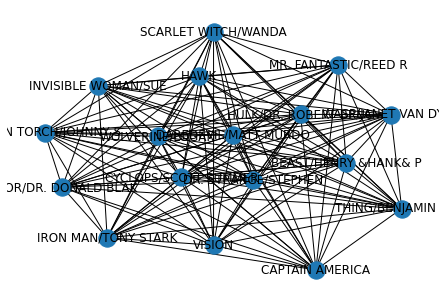

In [48]:
plt.clf()
nx.draw(subsetA, with_labels=True)
plt.show()

In [49]:
nx.info(subsetB)

'Graph with 3 nodes and 3 edges'

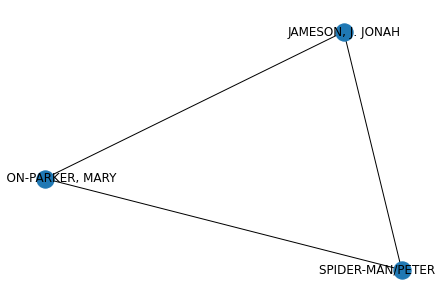

In [50]:
plt.clf()
nx.draw(subsetB, with_labels=True)
plt.show()

### Functionality 5 - Extracting Communities

In [10]:
# remove the node with highest EBC score from the graph
def removeEdge(graph):
	# We use capacity attribute of edges here as weight because we want heroes that are mostly together in comics to be in the same community
	G_dict = nx.edge_betweenness_centrality(graph, weight='capacity')

	edge = sorted(G_dict.items(), key=lambda item: item[1], reverse = True)[0][0]
	graph.remove_edge(edge[0], edge[1])

	return graph

# we remove nodes with highest EBC score until we have only one connected component
def girvanNewman(graph):
	nConnectedComponents = nx.number_connected_components(graph)
	min_edges = 0

	while(nConnectedComponents == 1):
		graph = removeEdge(graph.copy())
		nConnectedComponents = nx.number_connected_components(graph)
		min_edges += 1

	return graph, min_edges

# function_5 takes in input some variable arguments in kwargs that must contain Hero_1 and Hero2 values
def function_5(G, N=0, **kwargs) :

	# we use divise method with Girvan Newman algorithm to extract communities from the graph
	G, min_edges = girvanNewman(G)

	# we extract the communities of the new graph
	communities = []
	connectedComponents = nx.connected_components(G)
	for community in connectedComponents :
		communities.append(community)

	# we check if hero1 and hero2 are in a same community
	same_community = False
	for community in communities :
		if kwargs['Hero_1'] in community and kwargs['Hero_2'] in community :
			same_community = True

	return min_edges, communities, same_community


In [39]:
min_edges, communities, same_community = ControllerSystem(5, G_heroes, 50, Hero_1='PUNISHER II/FRANK CA', Hero_2='HULK/DR. ROBERT BRUC')

In [40]:
same_community

False

In [41]:
min_edges

327

In [42]:
len(communities)

2

In [43]:
communities

[{'ANGEL/WARREN KENNETH',
  'ANT-MAN/DR. HENRY J.',
  'BEAST/HENRY &HANK& P',
  "BLACK PANTHER/T'CHAL",
  'BLACK WIDOW/NATASHA',
  'CANNONBALL II/SAM GU',
  'CAPTAIN AMERICA',
  'CAPTAIN BRITAIN/BRIA',
  'COLOSSUS II/PETER RA',
  'CYCLOPS/SCOTT SUMMER',
  'DAREDEVIL/MATT MURDO',
  'DR. DOOM/VICTOR VON',
  'DR. STRANGE/STEPHEN',
  'FURY, COL. NICHOLAS',
  'HAWK',
  'HERCULES [GREEK GOD]',
  'HULK/DR. ROBERT BRUC',
  'HUMAN TORCH/JOHNNY S',
  'ICEMAN/ROBERT BOBBY',
  'INVISIBLE WOMAN/SUE',
  'IRON MAN/TONY STARK',
  'JAMESON, J. JONAH',
  'JARVIS, EDWIN',
  'JONES, RICHARD MILHO',
  'MARVEL GIRL/JEAN GRE',
  'MR. FANTASTIC/REED R',
  'NELSON, FRANKLIN FOG',
  'NIGHTCRAWLER/KURT WA',
  'ODIN [ASGARDIAN]',
  'PARKER, MAY',
  'PROFESSOR X/CHARLES',
  'QUICKSILVER/PIETRO M',
  'RICHARDS, FRANKLIN B',
  'ROBERTSON, JOE',
  'ROGUE /',
  'SCARLET WITCH/WANDA',
  'SHADOWCAT/KATHERINE',
  'SHE-HULK/JENNIFER WA',
  'SILVER SURFER/NORRIN',
  'SPIDER-MAN/PETER PARKER',
  'STORM/ORORO MUNROE S',
  'S